In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from IPython.display import clear_output
from tqdm import tqdm

In [3]:
from typing import Dict, List, Tuple
from buffer_pool_baseline.timer import Time
from buffer_pool_baseline.cache import Cache
from buffer_pool_baseline.strategy import EvictionStrategy
from buffer_pool_baseline.environment import Query

In [4]:
%matplotlib inline

In [5]:
def setup():
    
    t = Time(0)
    
    c = Cache(cache_size, t, equate_id_to_value=True)
    
    start = random.randint(0, 20)
    end = start + 5
    
    start_2 = start + random.randint(0, 5)
    end_2 = start_2 + 5
    
    loop_size = random.randint(1, 3)
    
    select = Query(query_type = "select", time=t, parameters={"start": start, "end": end})
    env = Query(query_type="join", time=t, parameters={"start_table_1": start, "end_table_1": end, 
                                                       "start_table_2": start_2, "end_table_2": end_2})
    env.set_query_cache(c)
    
    c.add_element(random.randint(0, 30))
    c.add_element(random.randint(0, 30))
    c.add_element(random.randint(0, 30))
    c.add_element(random.randint(0, 30))
    return env

In [6]:
def multisetup():
    
    t = Time(0)
    
    c = Cache(cache_size, t, equate_id_to_value=True)
    
    start = random.randint(0, 20)
    end = start + 5
    
    join_start = random.randint(end+5, end+15)
    join_end = join_start + 5
    
    start_2 = join_start + random.randint(5, 10)
    end_2 = start_2 + 5
    
    loop_size = random.randint(1, 3)
    
#     Change queries as per use case here! Name them select and join_query if you are lazy.

    select = Query(query_type = "select", time=t, parameters={"start": start, "end": end, "loop_size": loop_size})
#     join_query = Query(query_type = "sequential", time=t, parameters={"start": start_2, "end": end_2, "loop_size": loop_size})
    
#     select = Query(query_type = "join", time=t, parameters={"start_table_1": join_start, "end_table_1": join_end, 
#                                                             "start_table_2": start_2, "end_table_2": end_2})
    
#     select = Query(query_type="join", time=t, parameters={"start_table_1": join_start, "end_table_1": join_end, 
#                                                        "start_table_2": start_2, "end_table_2": end_2})
    
    join_query = Query(query_type="select", time=t, parameters={"start": start+random.randint(0,3), "end": start+5, "loop_size": loop_size})
    
#     c.add_element(random.randint(100, 300))
#     c.add_element(random.randint(100, 300))
#     c.add_element(random.randint(100, 300))
#     c.add_element(random.randint(100, 300))
    select.set_query_cache(c)
    join_query.set_query_cache(c)
    
    return select, join_query  

In [7]:
def get_query(query_type, table_size, loop_size):
    t = Time()
    
    if query_type == "sequential":
        return Query(query_type="sequential", time=t, parameters={"start": 0, "end": table_size, "loop_size": loop_size})
    
    if query_type == "select":
        return Query(query_type="select", time=t, parameters={"start": 0, "end": table_size})
    
    if query_type == "join":
        return Query(query_type="join", time=t, parameters={"start_table_1": 0, "end_table_1": 10, 
                                                            "start_table_2": 0, "end_table_2": 10})
    

In [8]:
def get_time_steps_per_query(table_size, cache_size, loop_size):
    time_steps = {}
    
    query_types = ["sequential", "select", "join"]
    
    for query in query_types:
        t = Time(0)
        env = get_query(query, table_size, loop_size)
        c = Cache(cache_size, t, equate_id_to_value=True)
        env.set_query_cache(c)

        while not env.is_done():
            env.step("mru")

        time_steps[query] = env.time.now()
    
    return time_steps

In [9]:
def encode_queries(query_type, time_step, max_time_steps):
    return max_time_steps[query_type] + time_step

In [10]:
max_time_steps = get_time_steps_per_query(10, 4, 5)

In [11]:
alpha = 0.1
gamma = 0.9
epsilon = 0.1

# For plotting metrics
all_epochs = []
all_penalties = []

epsilon_greedy = True
alpha_decay = True

In [12]:
q_values_cumulative = []
old_q = np.zeros([1000, 4])
q_table = np.zeros([1000, 4])
cache_size = 4
number_of_runs = 100000

In [13]:
epsilon_div = number_of_runs / 6
alpha_div = number_of_runs / 6

In [14]:
def evaluate_policy(query, q_table):
    cache_map_policy = []
    
    start_index = max_time_steps[query.query_type]
    
    reward = 0
    
    for d in q_table[start_index:]:
        action = ["mru", "lru", "lfu", "fifo"][np.argmax(d)]
#         print(action)
        cache_map_policy.append({"action": action, 
                                 "cache": query.cache.cache_map.copy().keys(),
                                "which_element": query.parameters.copy()})
        query.step(action)
        
        if query.is_done():
            break
    
    hits, misses = query.step()
    reward = hits -  misses
    return hits, misses
    

In [15]:
def get_baseline(query, action = "lru"):
    cache_map_baseline = []
    
    while not query.is_done():
        query.step(action)
        cache_map_baseline.append({"cache": query.cache.cache_map.copy().keys(), 
                                   "which_element": query.parameters.copy()})
        
    hits, misses = query.step()
    return hits, misses

In [16]:
def compare_query_reward(env, q_table, t, c, c2,c3):
    
    params_baseline = env.parameters.copy()
    params_random = env.parameters.copy()
    params_policy = env.parameters.copy()
    query_type = env.query_type
    
    query_baseline = Query(query_type=query_type, parameters=params_baseline, time=t)
    
    query_baseline.set_query_cache(c)
    
    query_baseline_random = Query(query_type=query_type, parameters=params_random, time=t)
    query_baseline_random.set_query_cache(c2)
    
    query_policy = Query(query_type=query_type, parameters=params_policy, time=t)
    query_policy.set_query_cache(c3)
    
    hits_policy, misses_policy = evaluate_policy(query_policy, q_table)
    hits_baseline, misses_baseline = get_baseline(query_baseline)
    hits_random, misses_random = get_baseline(query_baseline_random, "random")
    
    return {"hits_baseline": hits_baseline, "misses_baseline": misses_baseline,
           "hits_policy": hits_policy, "misses_policy": misses_policy, "tm": query_baseline.time.now()}

In [17]:
encoded_state = []

# number_of_runs = 1
def run_multiple():
    global epsilon, alpha
    
    cum_reward_plot = []
    q_values_cumulative = []
    reward_policy = []
    
    
    for i in tqdm(range(1, number_of_runs+1)):

        q1, q2 = multisetup()
        state = encode_queries(q1.query_type, q1.time.now(), max_time_steps)

        penalties, reward, = 0, 0
        done = False
        previous_hit, previous_miss = 0, 0
        cum_reward = 0
        tm = 0
        
        old_q = q_table.copy()
        
        while (not q1.is_done() or not q2.is_done()):
            if q1.is_done():
                env = q2
            else:
                env = q1
            
            if epsilon_greedy:
                epsilon = 0.1/pow(10, round(i/epsilon_div))
            
            if random.uniform(0, 1) < epsilon:
                action = random.choice(env.actions) # Explore action space
            else:
                _action_ = np.argmax(q_table[state]) # Exploit learned values
                action = ["mru", "lru", "lfu", "fifo"][_action_]

            hits, miss = env.step(action)
            next_state = encode_queries(env.query_type, env.time.now(), max_time_steps)
            encoded_state.append(next_state)
        
            reward = hits - previous_hit
            penalties = miss - previous_miss

            previous_hit = hits
            previous_miss = miss

            _action_ = ["mru", "lru", "lfu", "fifo"].index(action)

            old_value = q_table[state, _action_]
            next_max = np.max(q_table[next_state])

            r = reward - penalties
#             if r > 0:
#                 print(q1.parameters, q2.parameters)
            
            if alpha_decay:
                alpha = 0.01/pow(10, round(i/alpha_div))
                
            new_value = (1 - alpha) * old_value + alpha * (r + gamma * next_max)
            
            q_table[state, _action_] = new_value
            state = next_state
            cum_reward += r
            tm += 1
            
        q_values_cumulative.append({"q_values_cumulative": sum(sum(abs(old_q - q_table)))})
        hits, misses = q1.step()
        hits2, misses2 = q2.step()
        
        cum_reward_plot.append({"reward": cum_reward, "epoch": i, "time": tm, "hits": hits+hits2, "misses": misses + misses2})
        
        if i % 100 == 0:
            total_hits = 0
            total_misses = 0

            for i in range(100):
                q1, q2 = multisetup()
                t = Time(0)
                c = Cache(cache_size, time=t, equate_id_to_value=True)
                c2 = Cache(cache_size, time=t, equate_id_to_value=True)
                c3 = Cache(cache_size, time=t, equate_id_to_value=True)
                
                r1 = compare_query_reward(q1, q_table, t, c, c2, c3) 
                r2 = compare_query_reward(q2, q_table, t, c, c2, c3)
                
                total_r = {}
                for x, y in r1.items():
                    total_r[x] = y

                for x, y in r2.items():
                    total_r[x] += y
                    
                tm = q1.time.now() + q2.time.now()
                total_hits += total_r["hits_policy"] / total_r["tm"]
                total_misses += total_r["misses_policy"] / total_r["tm"]
            
            reward_policy.append({"Total Hits": total_hits, "Total Misses": total_misses})
            
    return cum_reward_plot, q_values_cumulative, reward_policy
    print("Training finished.\n")


In [18]:
cum_reward_plot, q_values_cumulative, reward = run_multiple()

100%|█████████████████████████████████████████████████████████████████████████| 100000/100000 [02:01<00:00, 821.52it/s]


In [19]:
def compare_reward(query_type):
    
    env = setup()
    params_baseline = env.parameters.copy()
    params_random = env.parameters.copy()
    params_policy = env.parameters.copy()
    
    t = Time(0)
    query_baseline = Query(query_type=query_type, parameters=params_baseline, time=t)
    c = Cache(cache_size, time=t, equate_id_to_value=True)
    query_baseline.set_query_cache(c)
    
    query_baseline_random = Query(query_type=query_type, parameters=params_random, time=t)
    c2 = Cache(cache_size, time=t, equate_id_to_value=True)
    query_baseline_random.set_query_cache(c2)
    
    query_policy = Query(query_type=query_type, parameters=params_policy, time=t)
    c3 = Cache(cache_size, time=t, equate_id_to_value=True)
    query_policy.set_query_cache(c3)
    
    hits_policy, misses_policy = evaluate_policy(query_policy, q_table)
    hits_baseline, misses_baseline = get_baseline(query_baseline)
    hits_random, misses_random = get_baseline(query_baseline_random, "random")
    
    return {"hits_random" : hits_random, "misses_random": misses_random, 
            "hits_baseline": hits_baseline, "misses_baseline": misses_baseline,
           "hits_policy": hits_policy, "misses_policy": misses_policy, "tm": query_baseline.time.now()}

In [20]:
df_metrics = pd.DataFrame(reward)

Text(0, 0.5, 'Hits')

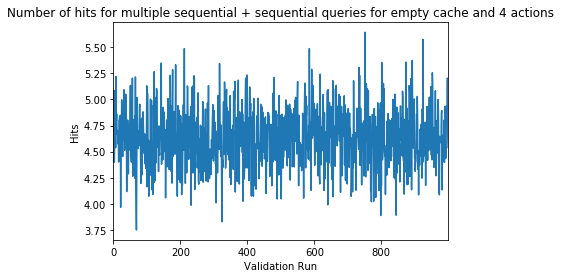

In [21]:
(df_metrics["Total Hits"]).plot()
plt.title("Number of hits for multiple sequential + sequential queries for empty cache and 4 actions")
plt.xlabel("Validation Run")
plt.ylabel("Hits")

In [22]:
# q1, q2 = multisetup()

# h1, miss1 = evaluate_policy(q1, q_table)
# h2, miss2 = evaluate_policy(q2, q_table)

In [23]:
# h1, miss1, h2, miss2

In [24]:
# q1, q2 = multisetup()
# get_baseline(q1), get_baseline(q2)

In [25]:
df_q_value = pd.DataFrame(q_values_cumulative)

In [26]:
# df_q_value.min(), df_q_value.max()

In [27]:
df = pd.DataFrame(cum_reward_plot)

In [28]:
df["r"] = df["reward"] / df["time"]

In [29]:
df.reward.max()

3

In [30]:
df["rolling_mean"] = df["r"].rolling(200).mean()

In [31]:
df_q_value = pd.DataFrame(q_values_cumulative)
df_q_value.head()
df_q_value["rolling"] = df_q_value.rolling(1000).mean()

Text(0, 0.5, 'Change in Q values')

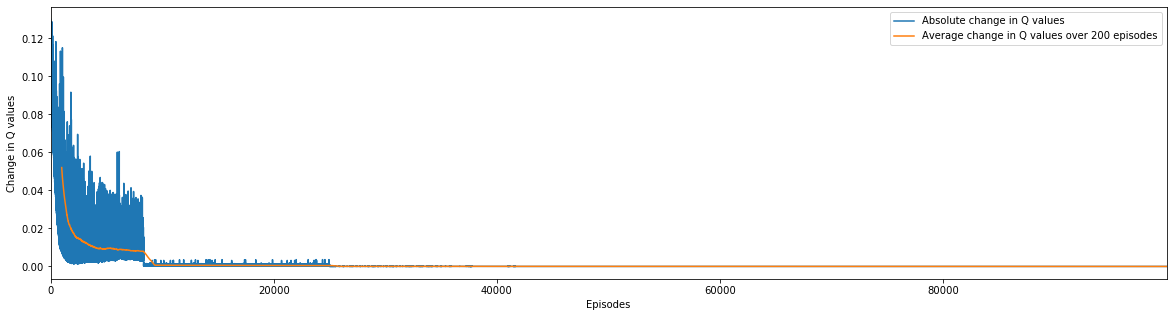

In [32]:
df_q_value.columns=["Absolute change in Q values", "Average change in Q values over 200 episodes"]
ax=df_q_value.plot(figsize=(20,5))
ax.set_xlabel("Episodes")
ax.set_ylabel("Change in Q values")

In [34]:
df

,reward,epoch,time,hits,misses,r,rolling_mean
0,3,1,8,4,6,0.375000,NaN
1,1,2,9,3,7,0.111111,NaN
2,1,3,7,2,5,0.142857,NaN
3,1,4,7,3,5,0.142857,NaN
4,1,5,7,3,5,0.142857,NaN
...,...,...,...,...,...,...,...
99995,1,99996,9,3,7,0.111111,0.135714
99996,1,99997,7,4,5,0.142857,0.135714
99997,1,99998,7,3,5,0.142857,0.135714
99998,1,99999,7,2,5,0.142857,0.135873


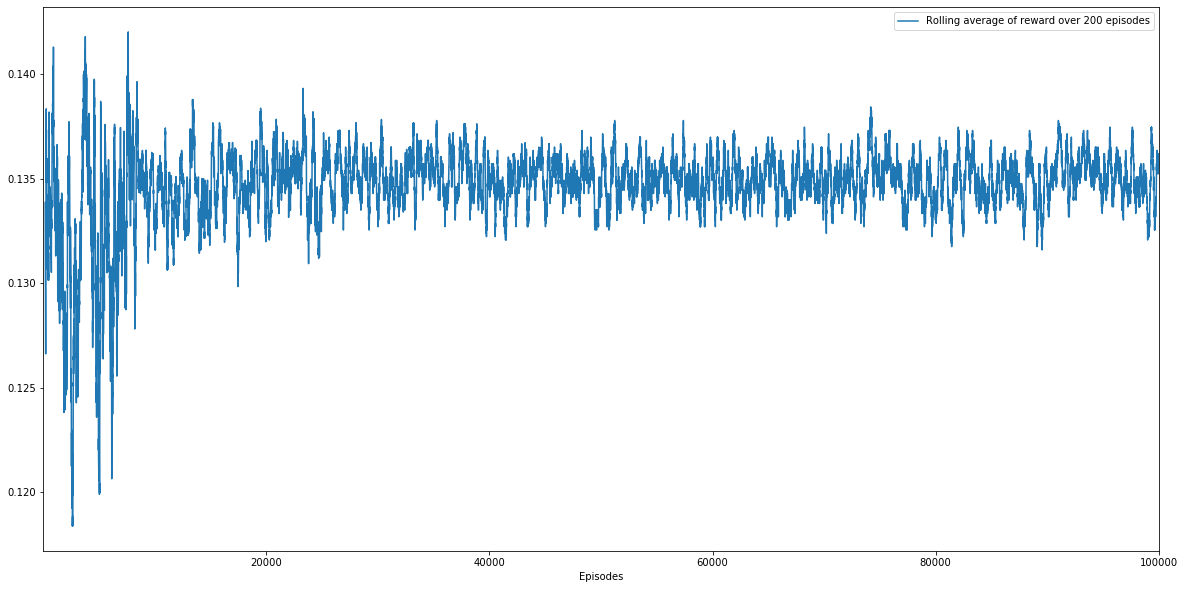

In [35]:
df.columns=['reward', 'Episodes', 'time', 'hits', 'misses', 'r', 'Rolling average of reward over 200 episodes']
df.plot(y="Rolling average of reward over 200 episodes", x="Episodes", figsize=(20, 10))

In [ ]:
max_time_steps

In [ ]:
# Heatmap
actions = ["MRU", "LRU", "LFU", "FIFO"]
fig, ax = plt.subplots()
im = ax.imshow(q_table[11:66])

# We want to show all ticks...
ax.set_xticks(np.arange(len(actions)))

ax.set_xticklabels(actions)


# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(q_table[11:66])):
    for j in range(len(actions)):
        #print(q_table[66+i, j])
        text = ax.text(j, i, round(q_table[11+i, j],4),
                       ha="center", va="center", color="w")
fig.set_figheight(40)
fig.set_figwidth(20)
ax.set_title("Actions chosen by our model for each time step")
plt.show()

In [ ]:
# def run_single():
#     global epsilon
    
#     cum_reward_plot = []
#     encoded_state = []

#     for i in tqdm(range(1, number_of_runs)):

#         env = setup()
#         state = encode_queries(env.query_type, env.time.now(), max_time_steps)

#         penalties, reward, = 0, 0
#         done = False
#         previous_hit, previous_miss = 0, 0
#         cum_reward = 0
#         tm = 0

#         while not done:

#             if random.uniform(0, 1) < epsilon:
#                 action = random.choice(env.actions) # Explore action space
#             else:
#                 _action_ = np.argmax(q_table[state]) # Exploit learned values
#                 action = "mru" if _action_ == 0 else "lru"

#             hits, miss = env.step(action)
#             next_state = encode_queries(env.query_type, env.time.now(), max_time_steps)
#             encoded_state.append(next_state)

#             reward = hits - previous_hit
#             penalties = miss - previous_miss

#             previous_hit = hits
#             previous_miss = miss

#             done = env.done

#             _action_ = 0 if action == "mru" else 1

#             old_value = q_table[state, _action_]
#             next_max = np.max(q_table[next_state])

#             r = reward - penalties
#             new_value = (1 - alpha) * old_value + alpha * (r + gamma * next_max)
#             q_table[state, _action_] = new_value
#             state = next_state
#             cum_reward += r
#             tm += 1

#         old_q = q_table.copy()

#         cum_reward_plot.append({"reward": cum_reward, "epoch": i, "time": tm})

#     print("Training finished.\n")